In [24]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Unfortunatley, YFinance does not provide the recommendations for all publicly traded companies.
### However, tech stocks and other large cap companies often work

In [25]:
#Change this variable to the ticker you are interested in analyzing (FAANG stocks work well and so do other large cap corps)
symbol = "NVDA"
ticker = yf.Ticker(symbol)

In [26]:
#Look at all reco types before we format them
df_base = ticker.recommendations.reset_index()
df = df_base.copy()
df['To Grade'].value_counts()

Buy                  114
Outperform            43
Hold                  31
Overweight            27
Neutral               21
Equal-Weight          17
Market Perform        12
Underperform           9
Underweight            8
Positive               6
Reduce                 4
Sell                   2
Negative               1
Perform                1
Equal-weight           1
Sector Perform         1
Sector Weight          1
Market Outperform      1
Strong Buy             1
Name: To Grade, dtype: int64

In [27]:
import datetime as dt
df['Date'] = df['Date'].dt.floor('D') # Remove seconds

In [28]:
df['To Grade'] = np.where((df['To Grade'].isin(['Outperform','Overweight','Positive','Market Outperform','Strong Buy'])),(
'Buy'),df['To Grade']) #Changing terms to Buy

In [29]:
df['To Grade'] = np.where((df['To Grade'].isin(['Neutral','Market Perform','Equal-Weight', 'Sector Perform','Perform','Equal-weight',
                                               'In-Line','Peer Perform','Sector Weight'])),
                          'Hold',df['To Grade']) #Changing terms to Hold

In [30]:
df['To Grade'] = np.where((df['To Grade'].isin(['Underperform','Underweight','Reduce','Negative'])),
'Sell',df['To Grade']) #Changing terms to Sell

In [31]:
df['To Grade'].value_counts()
#Check to make sure there aren't any significant reco types that we forgot to convert

Buy     192
Hold     85
Sell     24
Name: To Grade, dtype: int64

In [32]:
#Remove any values that are not buy/sell/hold
df = df.loc[(df['To Grade'] == 'Hold')|(df['To Grade']=='Buy')|(df['To Grade']=='Sell')].copy()

In [33]:
prices = yf.download(symbol,interval = '1d', progress=False)

### Create dfs for upcoming line/scatter plot

In [34]:
df_buy = df.loc[df['To Grade']=='Buy']
df_sell = df.loc[df['To Grade']=='Sell']

In [35]:
#get buy and sell in prices df so we can scatter plot them on the price plot
plot_buy = prices.merge(df_buy,on='Date', how = 'left')
plot_sell = prices.merge(df_sell,on='Date', how = 'left')

In [36]:
plot_buy = plot_buy.loc[plot_buy['To Grade']=='Buy']
plot_sell = plot_sell.loc[plot_sell['To Grade']=='Sell']

In [47]:
prices = prices.reset_index()

In [37]:
df1 = prices.merge(df, on='Date',how='left')
df1.drop(columns = ['Open','High','Low','Close','Volume','From Grade'],inplace= True)

### Calculating percent return after different time periods

In [38]:
dt_adj = 261/365 #use to adjust our desired windows as US has 261 working days a year

df1['30 day return'] = df1.loc[:,'Adj Close'].pct_change(periods = int(dt_adj*30))
df1['90 day return'] = df1.loc[:,'Adj Close'].pct_change(periods = int(dt_adj*90))
df1['180 day return'] = df1.loc[:,'Adj Close'].pct_change(periods = int(dt_adj*180))
df1['360 day return'] = df1.loc[:,'Adj Close'].pct_change(periods = int(dt_adj*360))
df1['2 year return'] = df1.loc[:,'Adj Close'].pct_change(periods = int(dt_adj*360*2))
df1['3 year return'] = df1.loc[:,'Adj Close'].pct_change(periods = int(dt_adj*360*3))
df1['5 year return'] = df1.loc[:,'Adj Close'].pct_change(periods = int(dt_adj*360*5))

In [39]:
#Shifting the df columns back so that the future return is on the day the reco was made
df1['30 day return'] = df1['30 day return'].shift(-int(dt_adj*30))
df1['90 day return'] = df1['90 day return'].shift(-int(dt_adj*90))
df1['180 day return'] = df1['180 day return'].shift(-int(dt_adj*180))
df1['360 day return'] = df1['360 day return'].shift(-int(dt_adj*360))
df1['2 year return'] = df1['2 year return'].shift(-int(dt_adj*360*2))
df1['3 year return'] = df1['3 year return'].shift(-int(dt_adj*360*3))
df1['5 year return'] = df1['5 year return'].shift(-int(dt_adj*360*5))

In [40]:
#Need to format df so that it can be used in a boxplot
return_gp = df1.groupby(['To Grade','Firm']).mean().reset_index()
return_gp.drop(columns = 'Adj Close',inplace=True)

return_melt = return_gp.melt(id_vars=['To Grade','Firm'])
return_melt_short = return_melt.loc[(return_melt['variable']=='30 day return')|
                                    (return_melt['variable']=='90 day return')|
                                    (return_melt['variable']=='180 day return')|
                                    (return_melt['variable']=='360 day return')]

return_melt_long = return_melt.loc[(return_melt['variable']=='2 year return')|
                                    (return_melt['variable']=='3 year return')|
                                   (return_melt['variable']=='5 year return')|
                                    (return_melt['variable']=='360 day return')]

### Uncomment and change the datemin and datemax variables to zoom in on certain dates

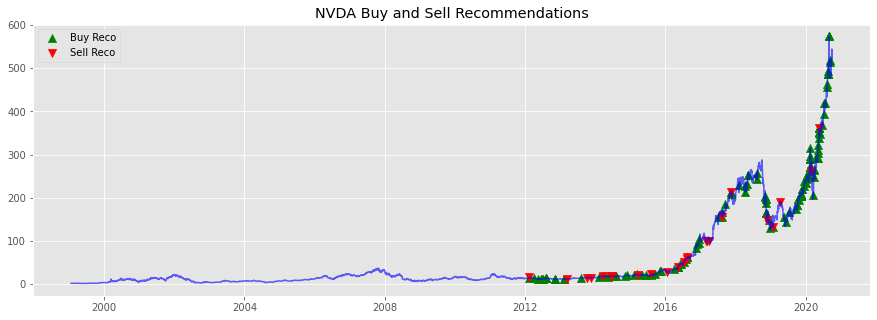

In [53]:
fig = plt.figure(figsize = (15,5))
plt.style.use('ggplot')

#variables for plot to make tweaking easier
line_alpha = 0.6
marker_alpha = 1
line_color = 'b'
buy_color = 'g'
sell_color = 'r'
marker_s = 70

ax = plt.subplot(1,1,1)
plt.plot(prices.Date, prices['Adj Close'], color =line_color, alpha=line_alpha)
plt.scatter(x = plot_buy.Date, y = plot_buy['Adj Close'], color = buy_color, marker = '^', label = 'Buy Reco',s=marker_s, alpha = marker_alpha)
plt.scatter(x = plot_sell.Date, y = plot_sell['Adj Close'], color = sell_color, marker = 'v', label = 'Sell Reco',s=marker_s, alpha=marker_alpha)
plt.title('{} Buy and Sell Recommendations'.format(symbol))
plt.legend(loc=2)

plt.show()
#datemin = dt.date(2018, 7, 1)
#datemax = dt.date(2020, 7, 24)
#ax.set_xlim(datemin, datemax)

<ipython-input-42-7f1ff58b7bec>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])


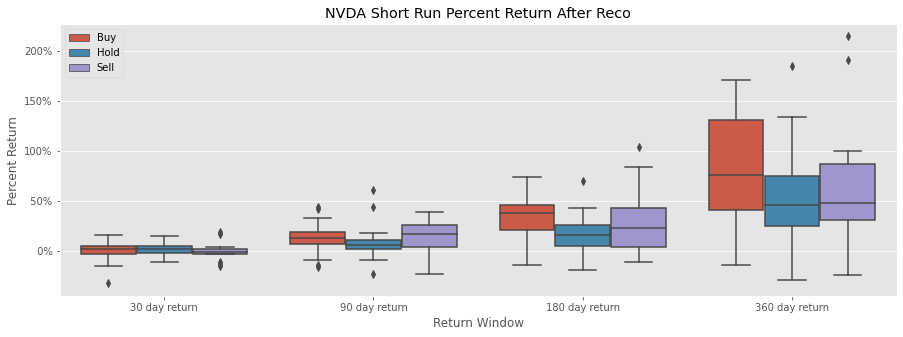

In [42]:
plt.figure(figsize = (15,5))


ax = sns.boxplot(x='variable',y = 'value', hue = 'To Grade',data = return_melt_short)
plt.title('{} Short Run Percent Return After Reco'.format(symbol))
plt.ylabel('Percent Return')
plt.xlabel('Return Window')
plt.legend(loc = 2)

#Format y ticks to percentage
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])

plt.show()

<ipython-input-43-7db5ac7e3c9e>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])


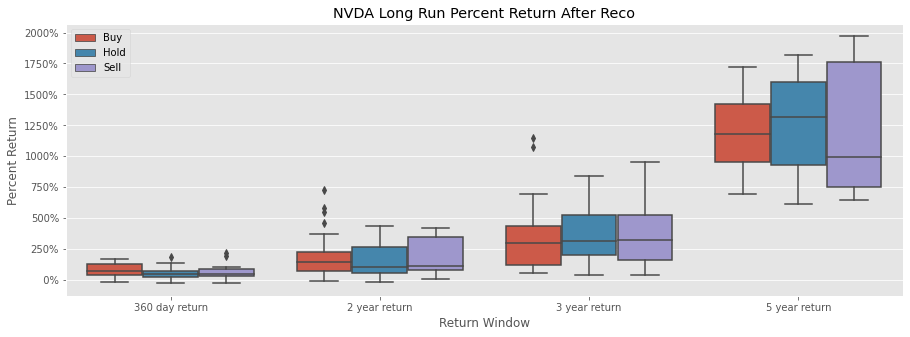

In [43]:
plt.figure(figsize = (15,5))
ax = sns.boxplot(x='variable',y = 'value', hue = 'To Grade',data = return_melt_long)
plt.title('{} Long Run Percent Return After Reco'.format(symbol))
plt.ylabel('Percent Return')
plt.xlabel('Return Window')
plt.legend(loc = 2)

#Format y ticks to percentage
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x * 100) for x in y_vals])

plt.show()